In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
from scipy.optimize import curve_fit

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

time = data[0,:] - 9.4068e8
solar = data[1,:]
earth = data[2,:]
rays = data[3,:]

def graph(array1, array2, start, num_points, step, plot_num):
    start = start * 10
    end = start + num_points * 10
    ax[plot_num].plot(array1[start:end:step], array2[start:end:step])

Text(0.5, 1.0, 'Time vs. Cosmic Rays')

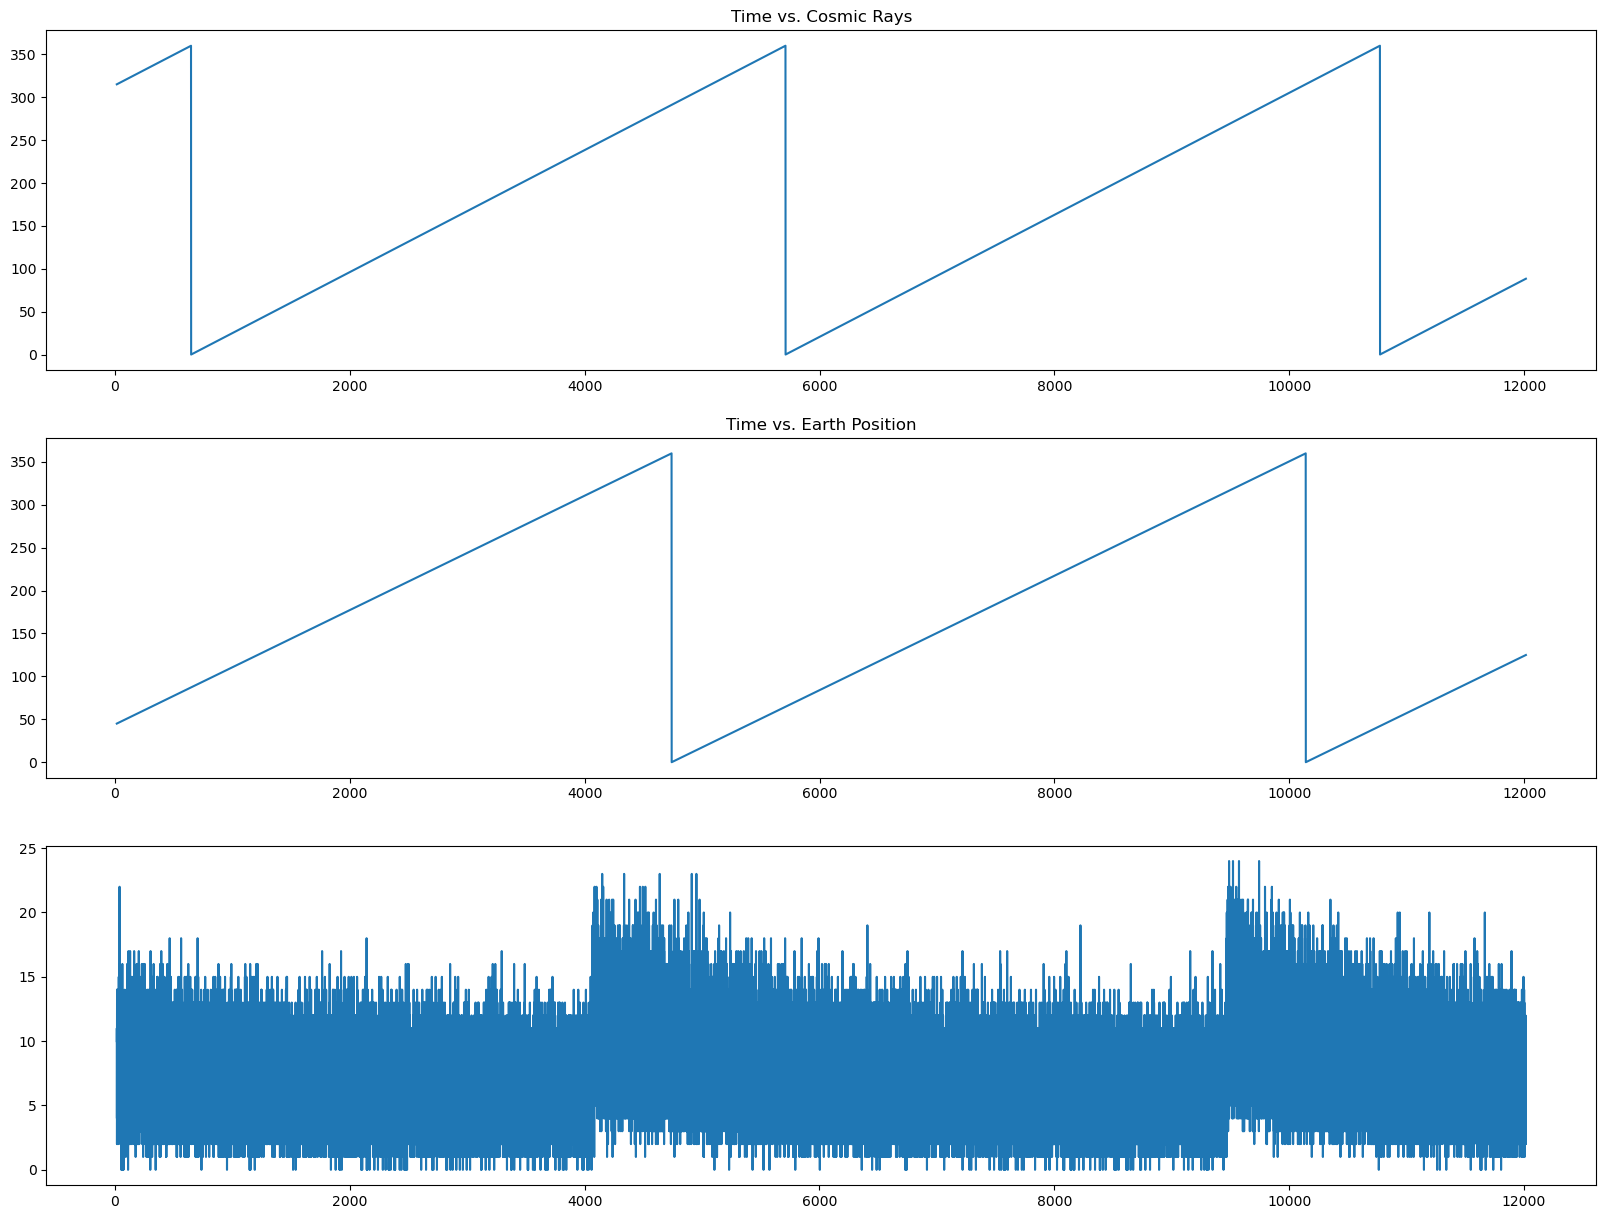

In [3]:
fig, ax = plt.subplots(3, 1, figsize = (20, 15))

graph(time, solar, 0, 12000, 10, 0)
ax[0].set_title("Time vs. Solar Position")

graph(time, earth, 0, 12000, 10, 1)
ax[1].set_title("Time vs. Earth Position")

graph(time, rays, 0, 12000, 1, 2)
ax[0].set_title("Time vs. Cosmic Rays")


Text(0.5, 1.0, 'Time vs. Gamma Rays')

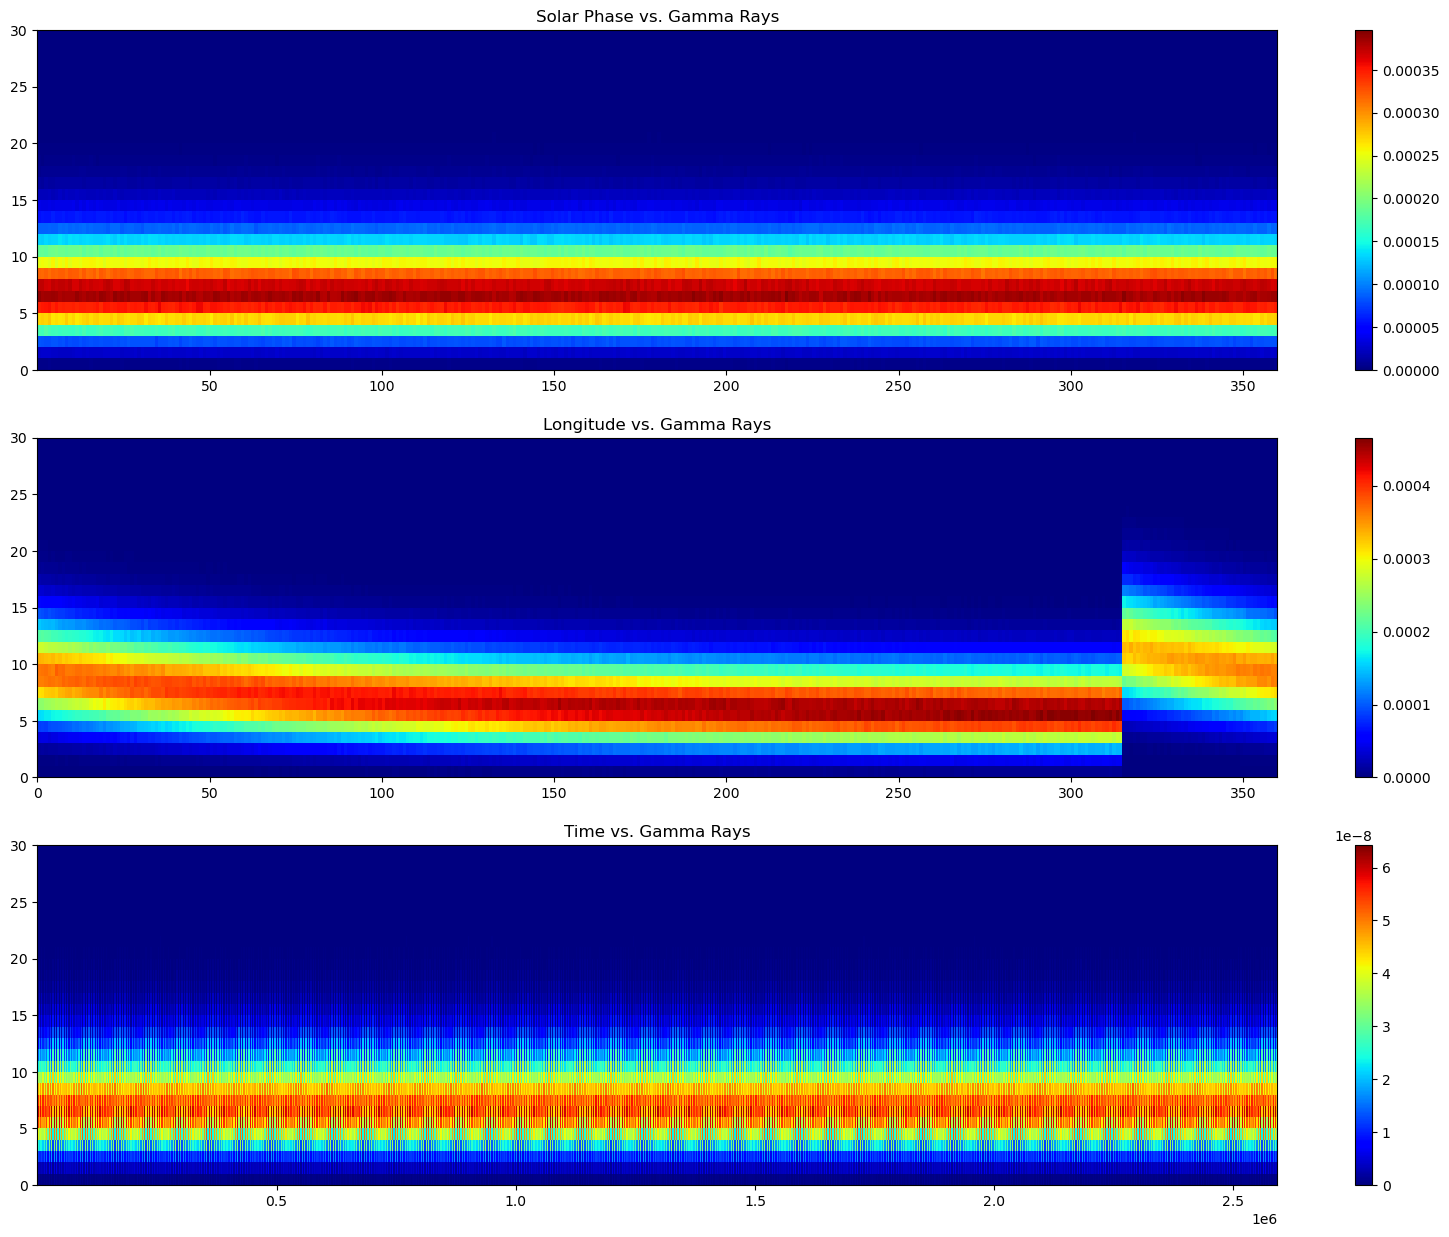

In [4]:
fig, ax = plt.subplots(3, 1, figsize = (20,15))

g = ax[0].hist2d(solar, rays, bins = [360,30], density = True, cmap = plt.cm.jet)
fig.colorbar(g[3], ax = ax[0])
ax[0].set_title("Solar Phase vs. Gamma Rays")

h = ax[1].hist2d(earth, rays, bins = [360,30], density = True, cmap = plt.cm.jet)
fig.colorbar(h[3], ax = ax[1])
ax[1].set_title("Longitude vs. Gamma Rays")

d = ax[2].hist2d(time, rays, bins = [1000,30], density = True, cmap = plt.cm.jet)
fig.colorbar(d[3], ax = ax[2])
ax[2].set_title("Time vs. Gamma Rays")

For background pdf we want f(d), where f gives the ray count as a function of degrees longitude. We know gamma rays normally follow a Poisson distribution, so we need a Poisson for each degree, which boils down to finding the mean gamma rays at each degree (or the mean as a function of degree). This is done from the 2D histogram for longitude. From here we can find d(t), where d gives the longitude at each time, and plug in for f(d(t)) to get f(t).

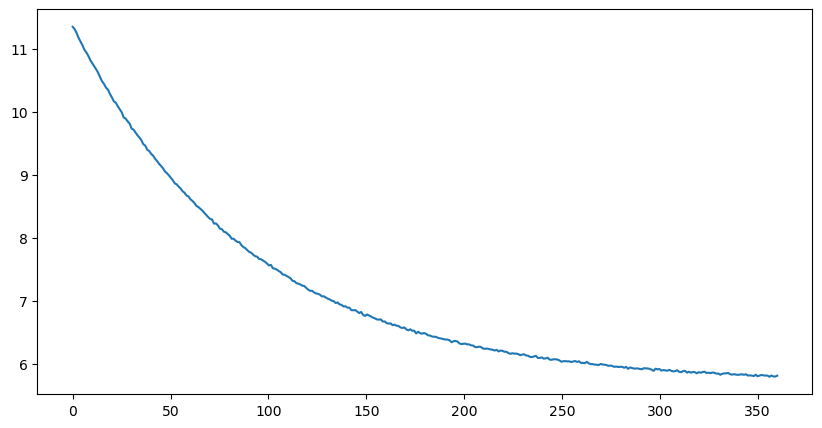

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))

# maxes = []
# for i in range(len(h[1]) - 1):
#     prob_index = np.argmax(h[0][i])
#     maxes.append(prob_index)
    
g = h

means = []
for i in range(len(g[1]) - 1):
    g[0][i] = g[0][i] / np.sum(g[0][i])
    av = 0
    for n in range(len(g[0][i]) - 1):
        av = av + (g[0][i][n] * n)
    means.append(av)

index = 0
for i in range(len(means) - 1):
    if(means[i] >= max(means)):
        index = i
        break

shifted_means = means[0:index]
for i in range(len(means) - index):
    shifted_means.insert(0, means[len(means) - (i + 1)])


ax.plot(np.linspace(0, 360, 360), shifted_means)

[ 6.0326141  -0.01109825  5.69951162  5.69829256]


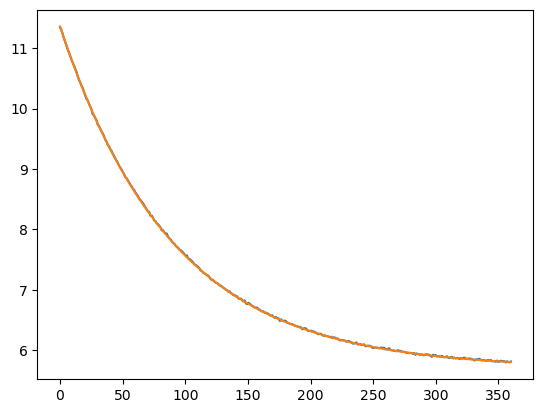

In [6]:
def fit(x, a, b, c, d):
    return a*np.exp(b*(x+c)) + d

guess_a = 5
guess_b = -0.01
guess_c = 15
guess_d = 6

init_guesses = [guess_a, guess_b, guess_c, guess_d]

fitpars, error = curve_fit(fit, np.arange(0, 360, 1), shifted_means, init_guesses)
print(fitpars)

fig, ax = plt.subplots(1, 1)

x = np.linspace(0, 360, 360)

f_x = fit(x, *fitpars)

def f_mean(x):
    return fitpars[0]*np.exp(fitpars[1]*(x+fitpars[2]))+fitpars[3]
    
ax.plot(x, shifted_means)
ax.plot(x, f_mean(x))

Average number of gamma-rays: $f(d) = 6.032e^{-0.01*(x + 5.70)} + 5.70$ for degree (d)

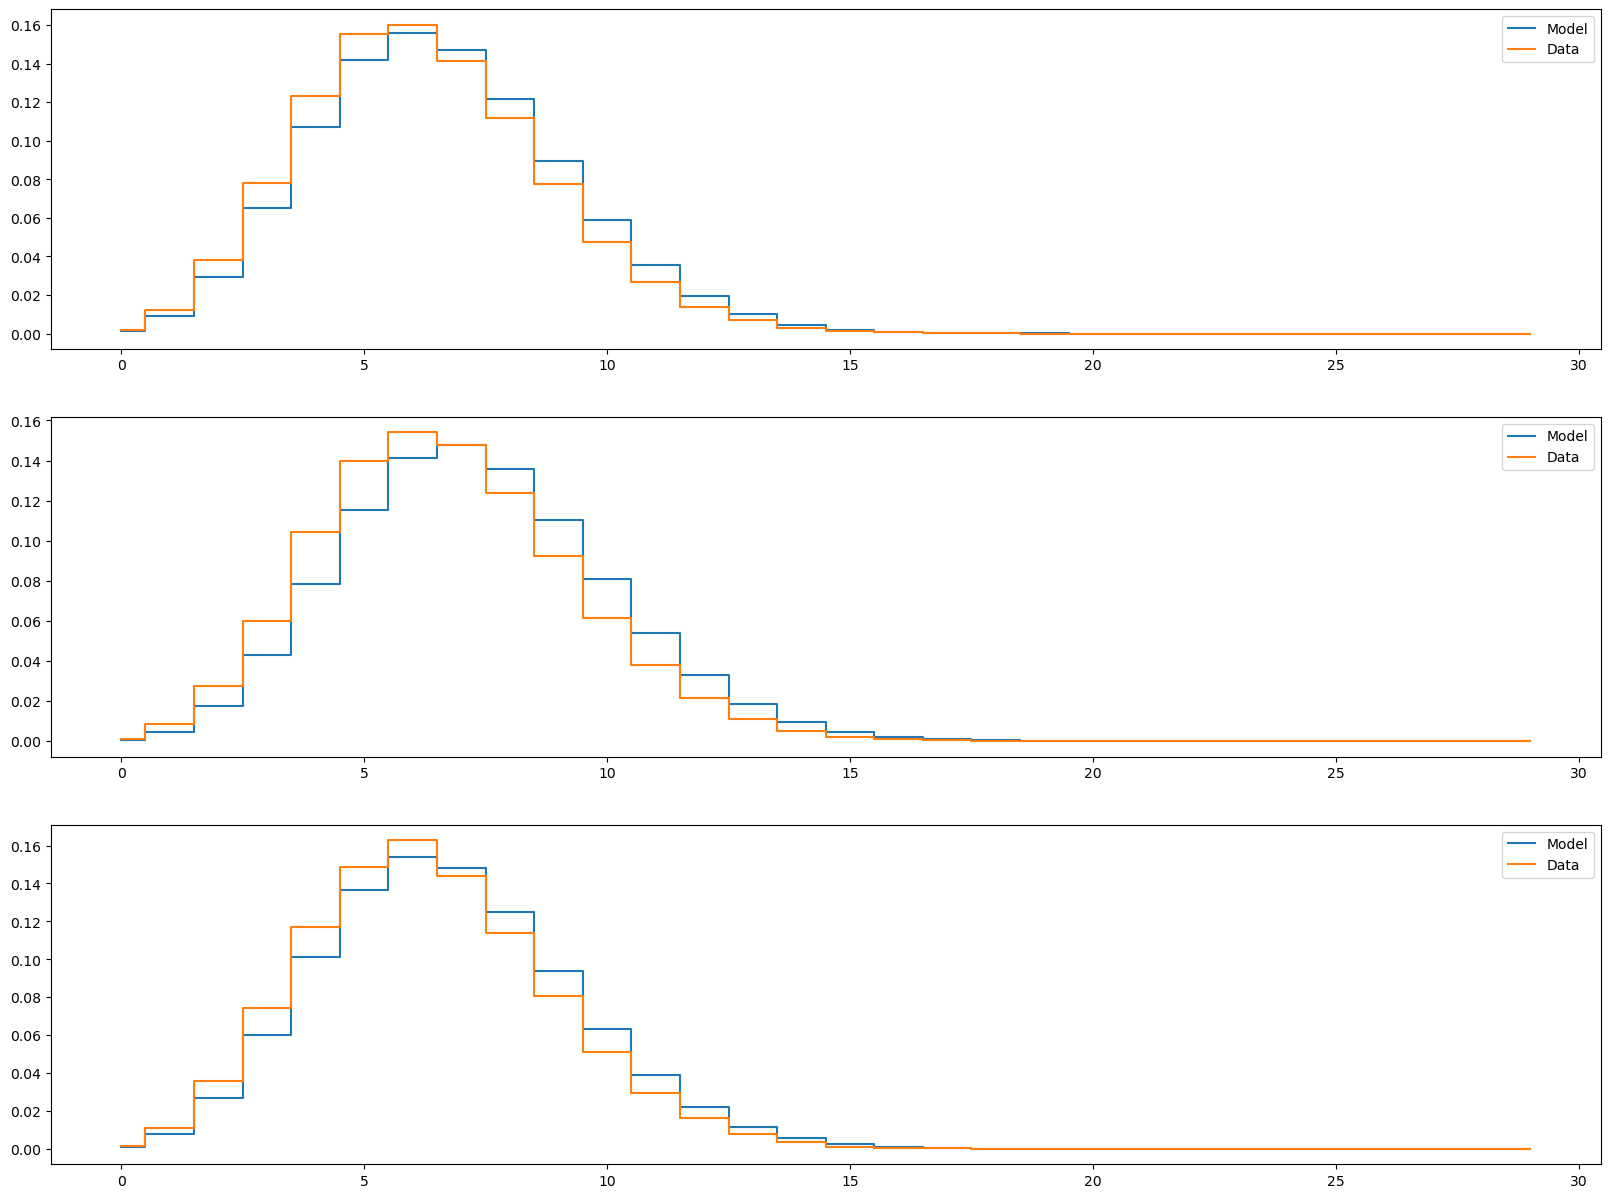

In [7]:
# Input a time (in seconds to the tenths place) to get the background model
# Starts at 0, not the actual GPS time


def time_to_deg(time):
    return int(earth[int(time * 10)])

def bkgd_model(time):
    return f_mean(earth[int(time * 10)])
    
mu = bkgd_model(4000.1)

fig, ax = plt.subplots(3, 1, figsize = (20,15))
x = np.arange(0, 30, 1)

ax[0].step(x, stats.poisson.pmf(x, bkgd_model(1800), loc = 0), where = 'mid')
ax[0].step(x, h[0][time_to_deg(1800)], where = 'mid')
ax[0].legend(["Model", "Data"])

ax[1].step(x, stats.poisson.pmf(x, bkgd_model(1000000), loc = 0), where = 'mid')
ax[1].step(x, h[0][time_to_deg(1000000)], where = 'mid')
ax[1].legend(["Model", "Data"])

ax[2].step(x, stats.poisson.pmf(x, bkgd_model(250000), loc = 0), where = 'mid')
ax[2].step(x, h[0][time_to_deg(250000)], where = 'mid')
ax[2].legend(["Model", "Data"])

# Problem 2

The background should be time independent and spatially consistent (the night sky does not change throughout time over the time the pictures were taken and is generally homogeneous).

0
{'38 72': 1, '123 173': 0}


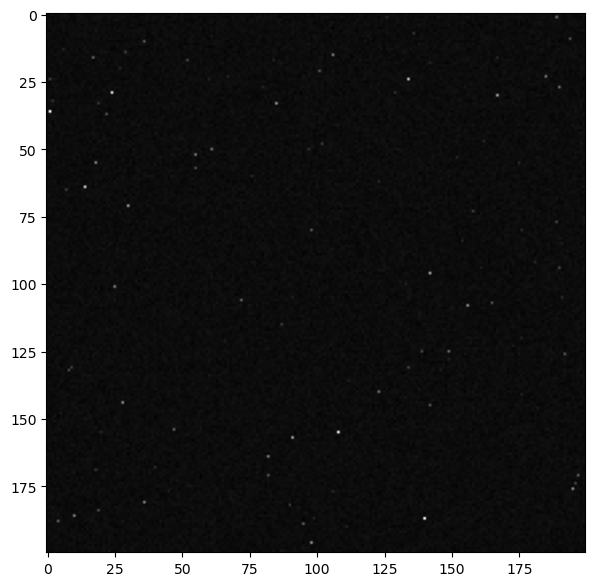

In [8]:
im = h5py.File('images.h5', 'r')
image1 = np.array(im.get('image1'))
imagestack = np.array(im.get('imagestack'))
# In Imagestack, the first index holds the y-value of the pixel, the second the x-index, the third the image (i.e. Imagestack[1][126][0] gives the 1st pixel from the top, 126th from the left,
# on the first image)

fig, ax = plt.subplots(1, 1, figsize = (7,7))
lin = np.linspace(-5, 5, 10000)

ax.imshow(imagestack[:,:,0], cmap = 'gray')

intensity = []
for i in range(len(imagestack[0][0])):
    intensity.append(imagestack[:,0,i])

avs = []
std = []
for i in range(len(intensity)):
    avs.append(np.sum(intensity[i]) / len(intensity[i]))
    std.append(scipy.stats.tstd(intensity[i]))


av_mean = np.sum(avs) / len(avs)
av_std = np.sum(std) / len(std)

bkgd_images = stats.norm.pdf(lin, loc = av_mean, scale = av_std)
prob5sigma = stats.norm.sf(5, loc = 0, scale = 1)
stat_sig = abs(stats.norm.ppf(prob5sigma, loc = av_mean, scale = av_std))


# ax[1].plot(lin, bkgd_images)

# Gathers which pixels are statistically significant
pixels = []
for i in range(len(imagestack[0])):
    for j in range(len(imagestack[0])):
        for n in range(len(imagestack[0][0])):
            if imagestack[i][j][n] >= stat_sig:
                pixels.append([i, j, n])

# Counts how many images each pixel appears in
pixel_count = dict()
for i in range(len(pixels)):
    current_pix = str(pixels[i][0]) + " " + str(pixels[i][1])
    if pixel_count.get(current_pix) is None:
        pixel_count[current_pix] = 1
    else:
        pixel_count[current_pix] = pixel_count.get(current_pix) + 1

# Creates a map of 
poss_transients = dict()
for key in pixel_count:
    if pixel_count[key] <= 1:
        poss_transients[key] = None
    
for i in range(len(pixels)):
    for key in poss_transients:
        if(str(pixels[i][0]) + " " + str(pixels[i][1]) == key):
            poss_transients[key] = pixels[i][2]
    
print(pixels[0][2])
print(poss_transients)

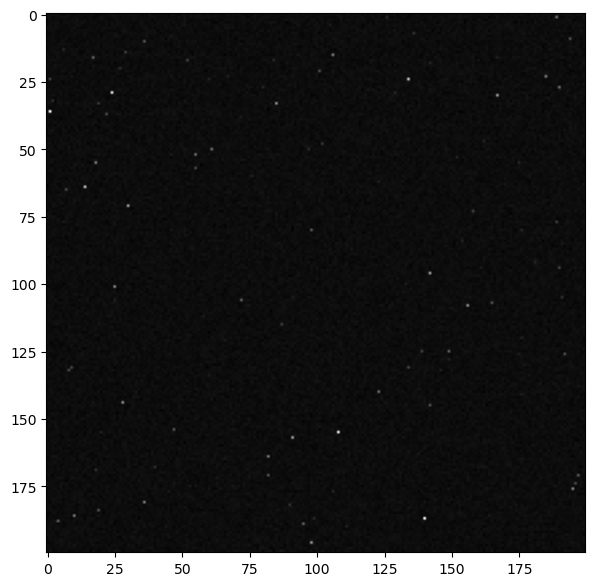

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.imshow(imagestack[:,:,1], cmap = 'gray')

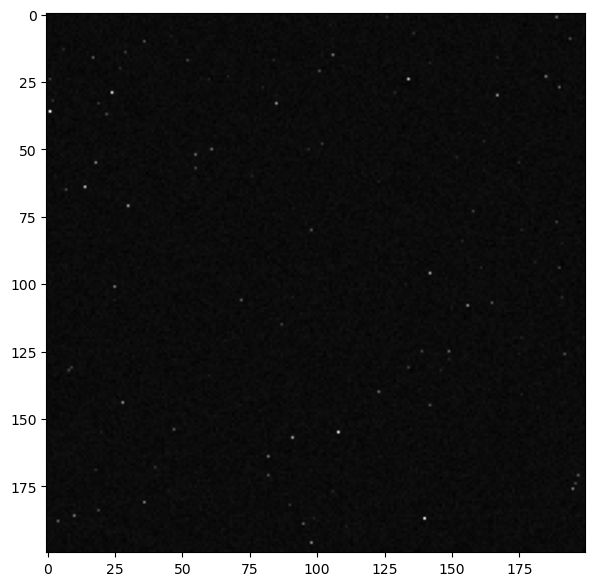

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.imshow(imagestack[:,:,2], cmap = 'gray')

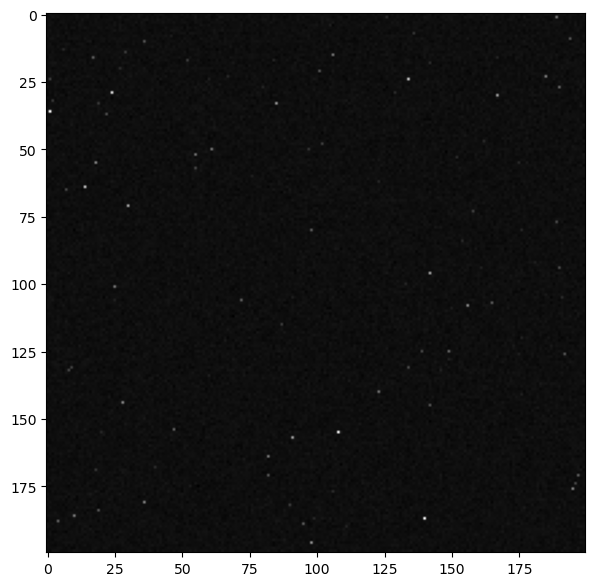

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.imshow(imagestack[:,:,3], cmap = 'gray')

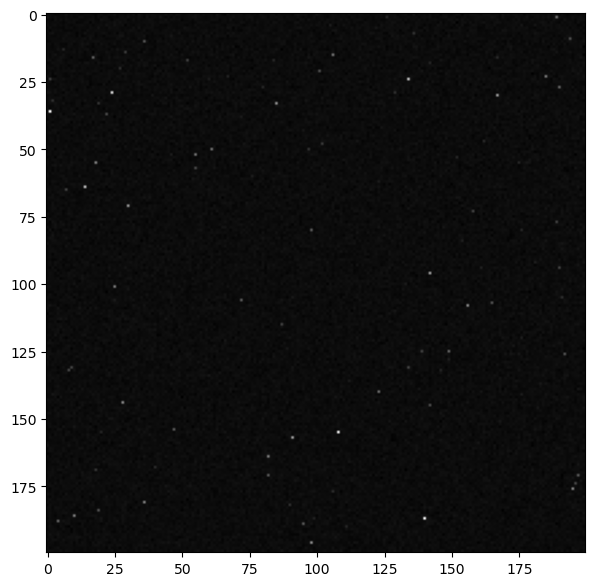

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.imshow(imagestack[:,:,4], cmap = 'gray')

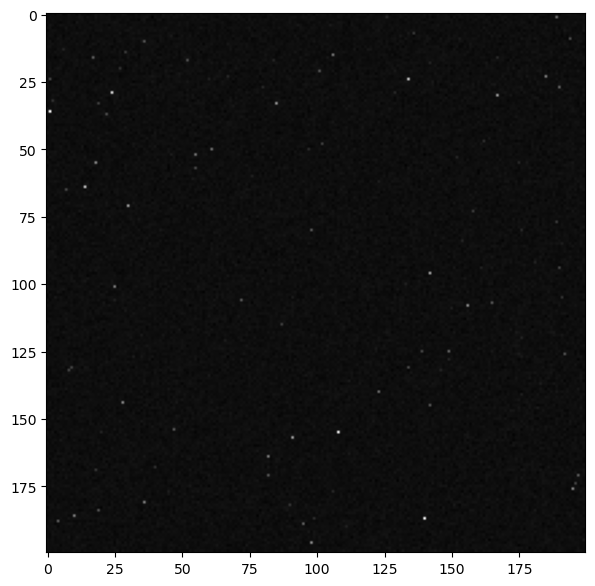

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.imshow(imagestack[:,:,5], cmap = 'gray')

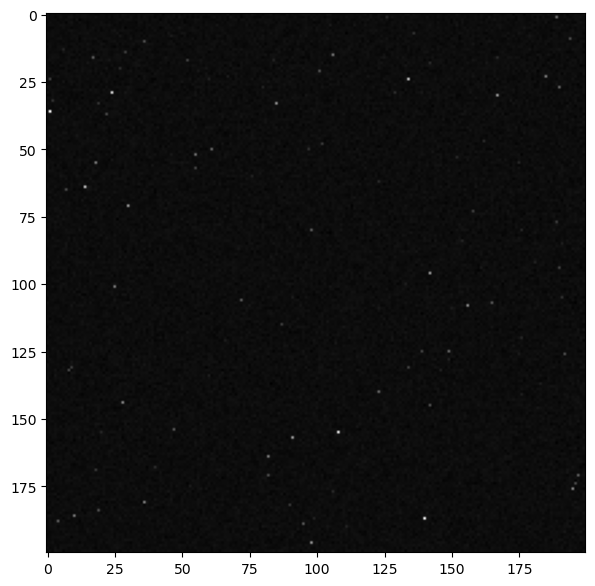

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.imshow(imagestack[:,:,6], cmap = 'gray')

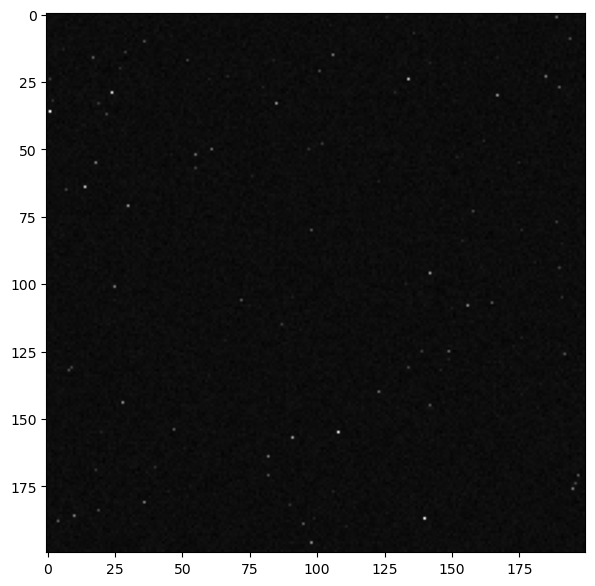

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.imshow(imagestack[:,:,7], cmap = 'gray')

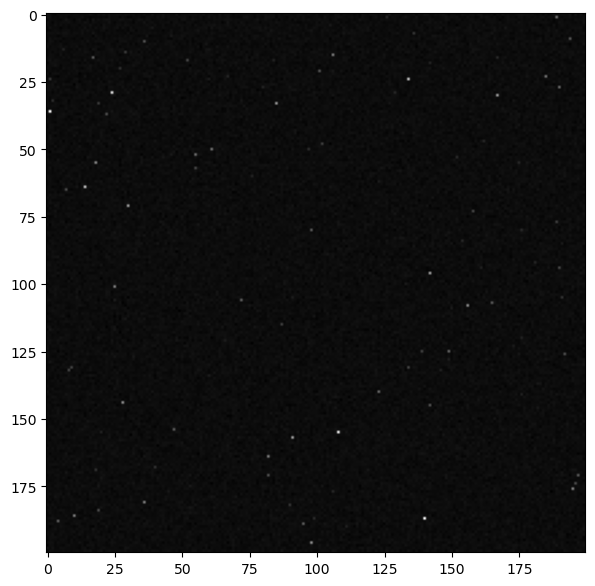

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.imshow(imagestack[:,:,8], cmap = 'gray')

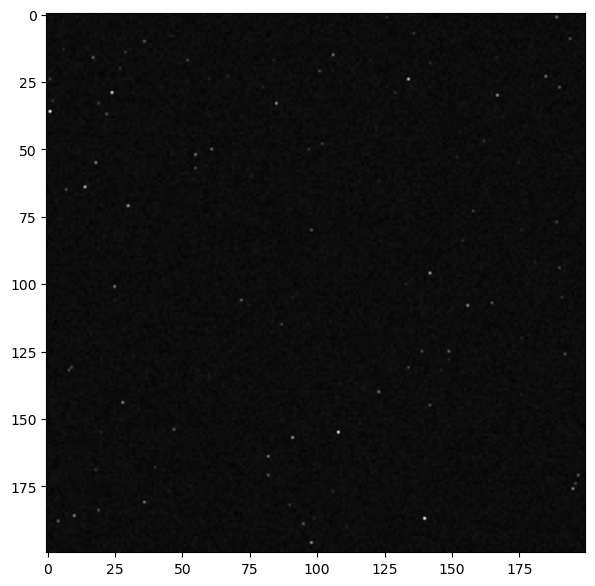

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.imshow(imagestack[:,:,9], cmap = 'gray')